In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
import pandas as pd
import numpy as np
import random
#import sc_toolbox

import rpy2.rinterface_lib.callbacks
import anndata2ri
import logging

from rpy2.robjects import pandas2ri
from rpy2.robjects import r

sc.settings.verbosity = 0
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

pandas2ri.activate()
anndata2ri.activate()

%load_ext rpy2.ipython

In [2]:
import anndata2ri
import rpy2.rinterface_lib.callbacks
import logging

In [3]:
import anndata
import os

In [4]:
%%R
library(edgeR)
#library(MAST)

In [1]:
data_dir = 'zenodo'

In [20]:
anndata2ri.activate()

In [21]:
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [6]:
%%R
library(miloR)
library(igraph)

In [14]:
adata = sc.read(os.path.join(data_dir, 'adata_all_nk_milo.h5ad'))

/home/ubuntu/miniconda3/envs/scenic/lib/python3.9/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


In [9]:
%%R -i adata
adata

class: SingleCellExperiment 
dim: 13942 89850 
metadata(0):
assays(1): X
rownames(13942): LINC00115 FAM41C ... S100B PRMT2
rowData names(1): n_cells
colnames(89850): AAACCTGAGTGTCCAT_1-0 AAACCTGCACATGGGA_1-0 ...
  rGBM-05-3_AGGAAATCATTCATCT-1-0-1_abdelfattah_rGBM-05
  rGBM-05-3_TGACGCGGTGTCATTG-1-0-1_abdelfattah_rGBM-05
colData names(13): sample batch ... condition nhood_group
reducedDimNames(2): X_scVI UMAP
mainExpName: NULL
altExpNames(0):


In [12]:
%%R 
milo <- Milo(adata)
milo

class: Milo 
dim: 13942 89850 
metadata(0):
assays(1): X
rownames(13942): LINC00115 FAM41C ... S100B PRMT2
rowData names(1): n_cells
colnames(89850): AAACCTGAGTGTCCAT_1-0 AAACCTGCACATGGGA_1-0 ...
  rGBM-05-3_AGGAAATCATTCATCT-1-0-1_abdelfattah_rGBM-05
  rGBM-05-3_TGACGCGGTGTCATTG-1-0-1_abdelfattah_rGBM-05
colData names(13): sample batch ... condition nhood_group
reducedDimNames(2): X_scVI UMAP
mainExpName: NULL
altExpNames(0):
nhoods dimensions(2): 1 1
nhoodCounts dimensions(2): 1 1
nhoodDistances dimension(1): 0
graph names(0):
nhoodIndex names(1): 0
nhoodExpression dimension(2): 1 1
nhoodReducedDim names(0):
nhoodGraph names(0):
nhoodAdjacency dimension(2): 1 1


In [8]:
design_df = adata.obs[["sample","dataset","condition"]]
design_df.drop_duplicates(inplace=True)
design_df.index = design_df['sample']
design_df

/tmp/ipykernel_187070/2584068957.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  design_df.drop_duplicates(inplace=True)


,sample,dataset,condition
sample,,,
malm_PBMC_reference,malm_PBMC_reference,malm,reference
amir_PBMC_reference,amir_PBMC_reference,amir,reference
crinier_PBMC_reference,crinier_PBMC_reference,crinier,reference
yang_PBMC_reference,yang_PBMC_reference,yang,reference
leader_cite_lung_normal_reference,leader_cite_lung_normal_reference,leader_cite,reference
...,...,...,...
xie_glioblastoma_tumor,xie_glioblastoma_tumor,xie,tumor
bhaduri_glioblastoma_tumor,bhaduri_glioblastoma_tumor,bhaduri,tumor
wang2019_glioblastoma_tumor,wang2019_glioblastoma_tumor,wang2019,tumor


In [13]:
%%R 
milo <- buildGraph(milo, reduced.dim = 'X_scVI', k=400, d=20)

In [ ]:
%%R -i design_df -o DA_results
## Define neighbourhoods
milo <- makeNhoods(milo, reduced_dims = 'X_scVI', prop = 0.1, k = 400, d=20, refined = TRUE) ## 200

## Count cells in neighbourhoods
milo <- countCells(milo, meta.data = data.frame(colData(milo)), sample="sample")

## Calculate distances between cells in neighbourhoods
## for spatial FDR correction
milo <- calcNhoodDistance(milo, reduced.dim = 'X_scVI', d=20)

DA_results <- testNhoods(milo, reduced.dim = 'X_scVI', design = ~ condition, design.df = design_df)

In [ ]:
%%R
milo

In [ ]:
%%R
plotNhoodSizeHist(milo)

In [ ]:
%%R
library(dplyr)
library(patchwork)
library(ggplot2)

In [ ]:
%%R
ggplot(DA_results, aes(PValue)) + geom_histogram(bins=50)

In [ ]:
%%R
ggplot(DA_results, aes(logFC, -log10(SpatialFDR))) + 
  geom_point() +
  geom_hline(yintercept = -log10(0.05)) ## Mark significance threshold (10% FDR)
#ggsave('fc_p_val_da_res.pdf')

In [ ]:
%%R
milo <- buildNhoodGraph(milo)

In [ ]:
%%R
library(SingleCellExperiment)
library(scater)
#library(scran)

In [50]:
%%R
## Plot single-cell UMAP
umap_pl <- plotReducedDim(milo, dimred = "UMAP", colour_by="condition", text_by = "condition", 
                          text_size = 3, point_size=0.5) +
  guides(fill="none")

## Plot neighbourhood graph
nh_graph_pl <- plotNhoodGraphDA(milo, DA_results, layout="UMAP",alpha=0.05) 
  
umap_pl + nh_graph_pl +
  plot_layout(guides="collect")
    
ggsave('umap_and_nhood_graph.pdf')

Saving 6.67 x 6.67 in image


#### Group neighborhoods

In [49]:
%%R
library(scran)

In [50]:
%%R
milo <- logNormCounts(milo)

In [51]:
%%R
## Exclude zero counts genes
keep.rows <- rowSums(logcounts(milo)) != 0
milo <- milo[keep.rows, ]

In [ ]:
%%R
DA_results <- groupNhoods(milo, DA_results, max.lfc.delta = 1, overlap=60)
head(DA_results)

In [ ]:
%%R
plotNhoodGroups(milo, DA_results, layout="UMAP")

In [13]:
%%R -i design_df -o DA_results
DA_results <- testNhoods(milo, reduced.dim = 'X_scVI', design = ~ condition, design.df = design_df)

In [14]:
%%R
DA_results <- groupNhoods(milo, DA_results, max.lfc.delta = 1, overlap=60)
head(DA_results)

       logFC   logCPM          F       PValue          FDR Nhood   SpatialFDR
1 -0.6492438 8.537542  2.1510798 1.433071e-01 2.405339e-01     1 2.438446e-01
2 -0.4279079 8.246211  0.9976256 3.185293e-01 4.491548e-01     2 4.531628e-01
3  2.5527218 8.221212 24.2054865 1.298260e-06 1.433047e-05     3 1.522060e-05
4  2.9503801 9.854951 21.5847794 4.693416e-06 4.087281e-05     4 4.312082e-05
5  1.6635527 8.843683  8.6624609 3.450266e-03 1.067734e-02     5 1.100139e-02
6 -1.4854048 7.720288 13.5774409 2.626065e-04 1.172145e-03     6 1.216324e-03
  NhoodGroup
1          1
2          1
3          2
4          2
5          2
6          3


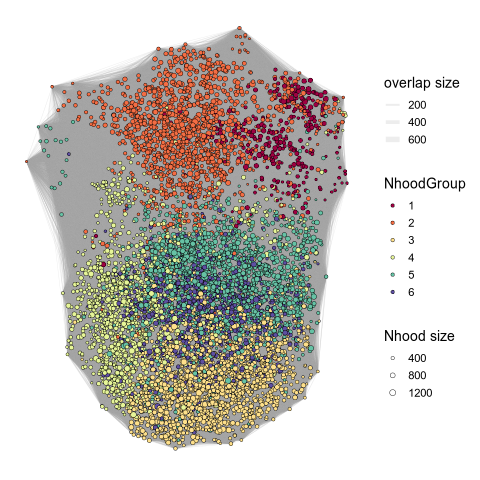

In [57]:
%%R
plotNhoodGroups(milo, DA_results, layout="UMAP")
#ggsave('nhoods_subset_annotation_new.pdf')

In [764]:
%%R
DA_results <- annotateNhoods(milo, DA_results, coldata_col = "condition")

In [753]:
%%R
DA_results$subset <- ifelse(DA_results$subset_low_fraction < 0.6, "Mixed", DA_results$subset_low)

In [755]:
%%R
## Save the adjacency matrix of the nhood graph
plotDAbeeswarm(DA_results, "subset")
ggsave('subset_beeswarm.pdf')

Saving 6.67 x 6.67 in image


/tmp/ipykernel_292557/2272589924.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=DA_results, y='condition_fraction', x='NhoodGroup', order=['1','2','3','4','5','6'],palette=colors).set(


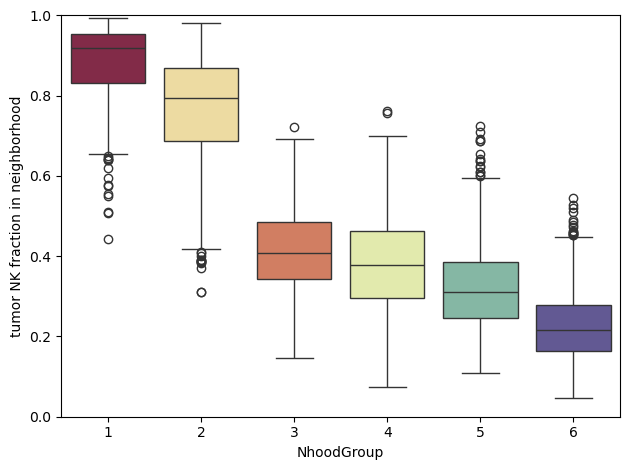

In [776]:
sns.boxplot(data=DA_results, y='condition_fraction', x='NhoodGroup', order=['1','2','3','4','5','6'],palette=colors).set(
    ylabel='tumor NK fraction in neighborhood'
)
plt.ylim(0,1)
plt.tight_layout()
#plt.show()
plt.savefig('fraction_tumor_nk_per_group.pdf')

In [318]:
%%R
library(svglite)

In [319]:
%%R
library(ggplot2)

In [203]:
%%R
DA_results$n
plotNhoodGroups(milo, DA_results, layout="UMAP")
ggsave('nhoods_subset_annotation.pdf')

Saving 6.67 x 6.67 in image


In [402]:
%%R
## Save the adjacency matrix of the nhood graph
plotDAbeeswarm(DA_results, "NhoodGroup")
ggsave('nhood_groups_beeswarm.svg', device=svglite)

Saving 6.67 x 6.67 in image


In [190]:
%%R
plotDAbeeswarm(DA_results, "NhoodGroup")
ggsave('nhoodgroups_beeswarm.pdf')

Saving 6.67 x 6.67 in image


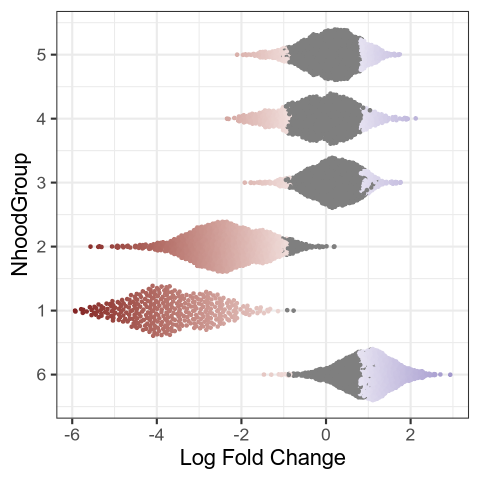

In [626]:
%%R
plotDAbeeswarm(DA_results, "NhoodGroup")

### nhood group composition

In [16]:
%%R -o nhood_counts,counts_row,counts_col
nhood_counts <- nhoodCounts(milo)
counts_row <- rownames(nhood_counts)
counts_col <- colnames(nhood_counts)

In [17]:
nhood_counts = pd.DataFrame(nhood_counts.todense(),columns=counts_col,index=counts_row)

In [18]:
%%R -o nhoods_df,nhoods_col,nhoods_row
nhoods_df <- milo@nhoods
nhoods_col <- colnames(nhoods_df)
nhoods_row <- rownames(nhoods_df)

In [19]:
nhoods_cells_df = pd.DataFrame(nhoods_df.todense(), index=nhoods_row, columns=nhoods_col)

In [21]:
%%R -o nhood_ind
nhood_ind <- milo@nhoodIndex

In [22]:
#nhood_ind

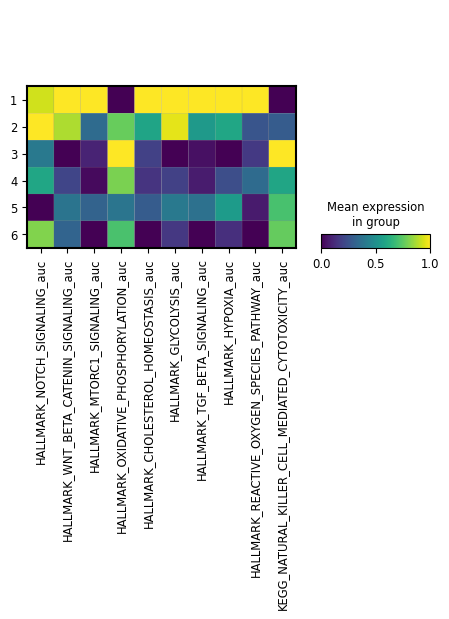

In [218]:
sc.pl.matrixplot(adata, ['HALLMARK_NOTCH_SIGNALING_auc', 'HALLMARK_WNT_BETA_CATENIN_SIGNALING_auc', 'HALLMARK_MTORC1_SIGNALING_auc', 
                         'HALLMARK_OXIDATIVE_PHOSPHORYLATION_auc', 'HALLMARK_CHOLESTEROL_HOMEOSTASIS_auc', 'HALLMARK_GLYCOLYSIS_auc',
                         'HALLMARK_TGF_BETA_SIGNALING_auc', 'HALLMARK_HYPOXIA_auc', 'HALLMARK_REACTIVE_OXYGEN_SPECIES_PATHWAY_auc',
                         'KEGG_NATURAL_KILLER_CELL_MEDIATED_CYTOTOXICITY_auc'], standard_scale='var', groupby='nhood_group', save='gene_sets_auc.pdf')

### DEG analysis

In [67]:
from bioinfokit import analys, visuz

In [627]:
%%R
nhood_markers_brights <- findNhoodGroupMarkers(milo, DA_results, aggregate.samples = TRUE, #assay='counts',
                                       sample_col = "replicate", subset.nhoods=(DA_results$NhoodGroup %in% c('1','2')))

head(nhood_markers_brights)

  GeneID       logFC_1 adj.P.Val_1      logFC_2 adj.P.Val_2
1   A1BG -1.821375e-02   0.3520755 1.821375e-02   0.3520755
2    A2M -7.278685e-03   0.7989859 7.278685e-03   0.7989859
3  A2ML1 -7.184633e-05   0.9415344 7.184633e-05   0.9415344
4 A4GALT -1.686608e-03   0.6078392 1.686608e-03   0.6078392
5  A4GNT -3.713818e-06   0.9899357 3.713818e-06   0.9899357
6   AAAS -4.518713e-03   0.8681140 4.518713e-03   0.8681140


In [628]:
%%R -o nhood_markers_brights
head(nhood_markers_brights)

  GeneID       logFC_1 adj.P.Val_1      logFC_2 adj.P.Val_2
1   A1BG -1.821375e-02   0.3520755 1.821375e-02   0.3520755
2    A2M -7.278685e-03   0.7989859 7.278685e-03   0.7989859
3  A2ML1 -7.184633e-05   0.9415344 7.184633e-05   0.9415344
4 A4GALT -1.686608e-03   0.6078392 1.686608e-03   0.6078392
5  A4GNT -3.713818e-06   0.9899357 3.713818e-06   0.9899357
6   AAAS -4.518713e-03   0.8681140 4.518713e-03   0.8681140


In [629]:
nhood_markers_brights.to_csv('nhood_markers_brights.csv')

In [698]:
lfc = 0.5
pval = 0.05
nhood_group = 1

visuz.GeneExpression.volcano(df=nhood_markers_brights, lfc=f'logFC_{nhood_group}', pv=f'adj.P.Val_{nhood_group}', 
                             show=False, geneid='GeneID', axtickfontname="DejaVu Sans", axlabelfontname="DejaVu Sans", 
                             #genenames=tuple(['CD7', 'FCER1G', 'GNLY', 'CCL4']),
                             genenames=tuple(nhood_markers_brights[((nhood_markers_brights[f'logFC_{nhood_group}'] > lfc) | (nhood_markers_brights[f'logFC_{nhood_group}'] < -lfc)) & (nhood_markers_brights[f'adj.P.Val_{nhood_group}'] < pval)]['GeneID']),
                             gstyle=1, lfc_thr=(lfc, lfc), pv_thr=(pval,pval), figname=f'nhood_aggregate_samples_group_{nhood_group}_markers', figtype='svg')

In [699]:
lfc = 0.5
pval = 0.05
nhood_group = 1

visuz.GeneExpression.volcano(df=nhood_markers_brights, lfc=f'logFC_{nhood_group}', pv=f'adj.P.Val_{nhood_group}', 
                             show=False, geneid='GeneID', axtickfontname="DejaVu Sans", axlabelfontname="DejaVu Sans", 
                             #genenames=tuple(['CD7', 'FCER1G', 'GNLY', 'CCL4']),
                             genenames=tuple(nhood_markers_brights[((nhood_markers_brights[f'logFC_{nhood_group}'] > lfc) | (nhood_markers_brights[f'logFC_{nhood_group}'] < -lfc)) & (nhood_markers_brights[f'adj.P.Val_{nhood_group}'] < pval)]['GeneID']),
                             gstyle=2, lfc_thr=(lfc, lfc), pv_thr=(pval,pval), figname=f'nhood_aggregate_samples_group_{nhood_group}_markers_arrows', figtype='svg')

In [635]:
nhood_group=1
nhood_markers_group = nhood_markers_brights[['GeneID', f'logFC_{nhood_group}', f'adj.P.Val_{nhood_group}']].copy()
nhood_markers_group.index = nhood_markers_group['GeneID']
nhood_markers_group['rank'] = nhood_markers_group[f'logFC_{nhood_group}']*-np.log10(nhood_markers_group[f'adj.P.Val_{nhood_group}'])
nhood_markers_group = nhood_markers_group['rank']
nhood_markers_group.index.name = None
nhood_markers_group = pd.DataFrame(nhood_markers_group)
nhood_markers_group.sort_values('rank', ascending=False)['rank'].to_csv(f'nhood_markers_rank_group_{nhood_group}.rnk', header=False, sep='\t')

In [636]:
%%R
nhood_markers_dim <- findNhoodGroupMarkers(milo, DA_results, aggregate.samples = TRUE, #assay='counts', 
                                       sample_col = "replicate", subset.nhoods=(DA_results$NhoodGroup %in% c('3','4','5','6')))

head(nhood_markers_dim)

  GeneID       logFC_6 adj.P.Val_6       logFC_3 adj.P.Val_3       logFC_4
1   A1BG  1.143753e-02   0.6515659 -1.290930e-02   0.5722673  4.512830e-03
2    A2M  1.263019e-02   0.5742989 -4.518398e-03   0.8815123 -5.293415e-03
3  A2ML1 -2.076052e-05   0.9530712 -5.185943e-07   1.0000000 -8.398161e-05
4 A4GALT  6.349454e-04   0.9666450  4.117019e-03   0.5617812 -1.663992e-03
5  A4GNT -4.103342e-03   0.7826754 -4.601346e-03   0.7389129 -1.653937e-03
6   AAAS -2.639772e-03   0.9530712  1.913860e-02   0.3560100 -3.546527e-03
  adj.P.Val_4       logFC_5 adj.P.Val_5
1           1 -0.0053690155   0.9974166
2           1 -0.0027311830   0.9974166
3           1  0.0001099479   0.9974166
4           1 -0.0021184914   0.9974166
5           1  0.0093508380   0.9974166
6           1 -0.0090117255   0.9974166


In [637]:
%%R -o nhood_markers_dim
head(nhood_markers_dim)

  GeneID       logFC_6 adj.P.Val_6       logFC_3 adj.P.Val_3       logFC_4
1   A1BG  1.143753e-02   0.6515659 -1.290930e-02   0.5722673  4.512830e-03
2    A2M  1.263019e-02   0.5742989 -4.518398e-03   0.8815123 -5.293415e-03
3  A2ML1 -2.076052e-05   0.9530712 -5.185943e-07   1.0000000 -8.398161e-05
4 A4GALT  6.349454e-04   0.9666450  4.117019e-03   0.5617812 -1.663992e-03
5  A4GNT -4.103342e-03   0.7826754 -4.601346e-03   0.7389129 -1.653937e-03
6   AAAS -2.639772e-03   0.9530712  1.913860e-02   0.3560100 -3.546527e-03
  adj.P.Val_4       logFC_5 adj.P.Val_5
1           1 -0.0053690155   0.9974166
2           1 -0.0027311830   0.9974166
3           1  0.0001099479   0.9974166
4           1 -0.0021184914   0.9974166
5           1  0.0093508380   0.9974166
6           1 -0.0090117255   0.9974166


In [638]:
nhood_markers_dim.to_csv('nhood_markers_dim.csv')

In [ ]:
%%R
nhood_markers_all <- findNhoodGroupMarkers(milo, DA_results, aggregate.samples = TRUE, #assay='counts', 
                                       sample_col = "replicate") #subset.nhoods=(DA_results$NhoodGroup %in% c('3','4','5','6')))

head(nhood_markers_all)

In [ ]:
%%R -o nhood_markers_all
head(nhood_markers_all)

In [ ]:
nhood_markers_all.to_csv('nhood_markers_all.csv')

In [731]:
nhood_markers_all

,GeneID,logFC_6,adj.P.Val_6,logFC_1,adj.P.Val_1,logFC_2,adj.P.Val_2,logFC_3,adj.P.Val_3,logFC_4,adj.P.Val_4,logFC_5,adj.P.Val_5
1,A1BG,-0.012470,0.741950,-0.010705,0.796948,0.023280,0.083849,-0.002738,0.962648,-0.004567,1.0,-0.006616,1.000000
2,A2M,-0.004837,0.845970,-0.002745,0.932424,0.002535,0.898848,-0.001996,0.932926,0.001551,1.0,0.000948,1.000000
3,A2ML1,-0.000043,1.000000,-0.000068,0.984599,-0.000155,0.898848,0.000630,0.166796,-0.000159,1.0,-0.000088,1.000000
4,A4GALT,-0.001746,0.833076,-0.001105,0.911341,0.006230,0.001406,-0.001059,0.864833,-0.001298,1.0,-0.003167,0.907902
5,A4GNT,-0.007857,0.848841,-0.006390,0.885111,-0.003323,0.906266,-0.006954,0.815868,-0.002241,1.0,0.018679,0.694468
...,...,...,...,...,...,...,...,...,...,...,...,...,...
13938,ZXDB,-0.002837,0.865182,-0.003467,0.819268,-0.001103,0.918104,0.005984,0.434712,-0.000897,1.0,0.000816,1.000000
13939,ZXDC,-0.021995,0.553358,0.024886,0.410543,-0.003124,0.933598,0.001034,1.000000,-0.008971,1.0,0.009416,1.000000
13940,ZYG11B,-0.013098,0.888687,-0.019950,0.799049,-0.005865,0.919600,0.040043,0.264984,-0.002554,1.0,-0.004516,1.000000
13941,ZYX,-0.005748,1.000000,-0.007659,0.980355,-0.004260,0.957843,0.073708,0.077759,0.012959,1.0,-0.059035,0.545319
